In [10]:
import numpy as np
import librosa
import csv
import pandas as pd
from scipy.signal import find_peaks

# Get the duration of the audio file
audio_file = "test.wav"
duration = librosa.get_duration(path=audio_file)

print("Duration of audio:", duration)

# Load the audio file
y, sr = librosa.load(audio_file, sr=None)

# Define chunk size and overlap
chunk_size = 8192  # Increase chunk size for higher resolution
overlap = 2048  # Ensure overlap is smaller than chunk size

# Calculate number of chunks
num_chunks = (len(y) - overlap) // (chunk_size - overlap)

# MIDI note number for A4 (440 Hz)
A4_note_number = 69

# Function to convert MIDI note number to frequency
def note_number_to_frequency(note_number):
    return 440 * 2 ** ((note_number - 69) / 12)

# Create a set to store unique note names
note_names = set()

# Loop over chunks to find all unique note names
for i in range(num_chunks):
    start = i * (chunk_size - overlap)
    end = start + chunk_size
    chunk = y[start:end]

    # Perform FFT on the chunk
    fft_result = np.fft.fft(chunk)

    # Calculate frequencies corresponding to FFT result
    frequencies = np.fft.fftfreq(len(chunk), d=1/sr)

    # Keep only positive frequencies
    positive_frequencies = frequencies[:len(chunk)//2]
    magnitude_spectrum = np.abs(fft_result)[:len(chunk)//2]

    # Limit frequencies to 4,000 Hz
    max_frequency_index = np.argmax(positive_frequencies >= 5000)
    positive_frequencies = positive_frequencies[:max_frequency_index]
    magnitude_spectrum = magnitude_spectrum[:max_frequency_index]

    # Find peaks above a certain threshold
    peaks, _ = find_peaks(magnitude_spectrum, height=10)

    # Fill set with note names for each peak
    for peak in peaks:
        frequency = positive_frequencies[peak]
        if frequency > 0:  # Check if frequency is positive
            try:
                note_number = round(12 * np.log2(frequency / note_number_to_frequency(A4_note_number)) + A4_note_number)
                if note_number >= 0 and note_number <= 127:
                    note_name = librosa.core.midi_to_note(note_number)
                    note_names.add(note_name)  # Collect note name
            except (ValueError, ZeroDivisionError, OverflowError):
                pass  # Skip frequencies resulting in errors

# Sort note names by their MIDI note numbers
sorted_note_names = sorted(list(note_names), key=lambda x: librosa.core.note_to_midi(x))

# Create a list to store data
data = []

# Loop over chunks again to process data
for i in range(num_chunks):
    start = i * (chunk_size - overlap)
    end = start + chunk_size
    chunk = y[start:end]

    # Perform FFT on the chunk
    fft_result = np.fft.fft(chunk)

    # Calculate frequencies corresponding to FFT result
    frequencies = np.fft.fftfreq(len(chunk), d=1/sr)

    # Keep only positive frequencies
    positive_frequencies = frequencies[:len(chunk)//2]
    magnitude_spectrum = np.abs(fft_result)[:len(chunk)//2]

    # Limit frequencies to 4,000 Hz
    max_frequency_index = np.argmax(positive_frequencies >= 4000)
    positive_frequencies = positive_frequencies[:max_frequency_index]
    magnitude_spectrum = magnitude_spectrum[:max_frequency_index]

    # Find peaks above a certain threshold
    peaks, _ = find_peaks(magnitude_spectrum, height=10)

    # Create a dictionary to store amplitude values for each note
    note_amplitudes = {}

    # Fill dictionary with amplitude values for peaks
    for peak in peaks:
        frequency = positive_frequencies[peak]
        if frequency > 0:  # Check if frequency is positive
            try:
                note_number = round(12 * np.log2(frequency / note_number_to_frequency(A4_note_number)) + A4_note_number)
                if note_number >= 0 and note_number <= 127:
                    note_name = librosa.core.midi_to_note(note_number)
                    amplitude_value = magnitude_spectrum[peak]
                    note_amplitudes[note_name] = amplitude_value
            except (ValueError, ZeroDivisionError, OverflowError):
                pass  # Skip frequencies resulting in errors
    
    # Map amplitude values to frame data
    frame_data = [note_amplitudes.get(note, 0) for note in sorted_note_names]

    data.append(frame_data)  # Append frame data to main data list

# Write data to CSV file
csv_file = "output.csv"
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write header row
    writer.writerow(sorted_note_names)
    
    # Write data rows
    for row in data:
        formatted_row = ['%.2f' % round(elem, 2) if elem != 0 else '0' for elem in row]
        writer.writerow(formatted_row)


# Read the CSV file
try:
    df = pd.read_csv(csv_file)

    # Drop columns with all zeros
    df = df.loc[:, (df != 0).any(axis=0)]

    # Write the modified DataFrame back to CSV
    df.to_csv("processed_output.csv", index=False)

    # Print number of rows and columns
    num_rows, num_columns = df.shape
    print(f"\nNumber of Frames: {num_rows}")
    print(f"Number of Notes Present: {num_columns}")
except pd.errors.EmptyDataError:
    print("EmptyDataError: No columns to parse from file")


Duration of audio: 3.237437641723356

Number of Frames: 22
Number of Notes Present: 52


In [11]:
import pandas as pd

# Read the CSV file
df = pd.read_csv("processed_output.csv")

# Find the highest cell value
highest_value = df.max().max()

# Filter out zeros and find the lowest value
lowest_nonzero_value = df[df != 0].min().min()

print("Highest cell value:", highest_value)
print("Lowest non-zero cell value:", lowest_nonzero_value)



Highest cell value: 1493.58
Lowest non-zero cell value: 10.04


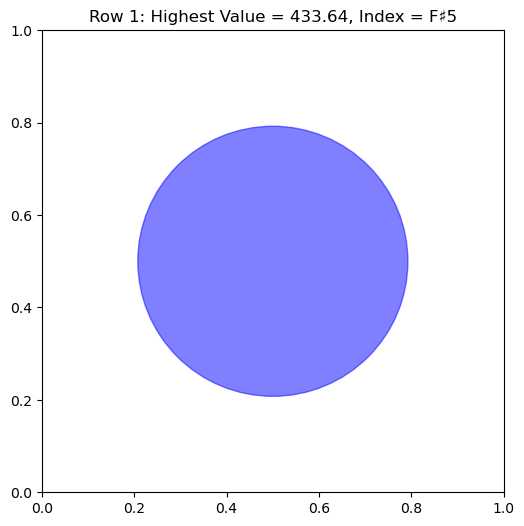

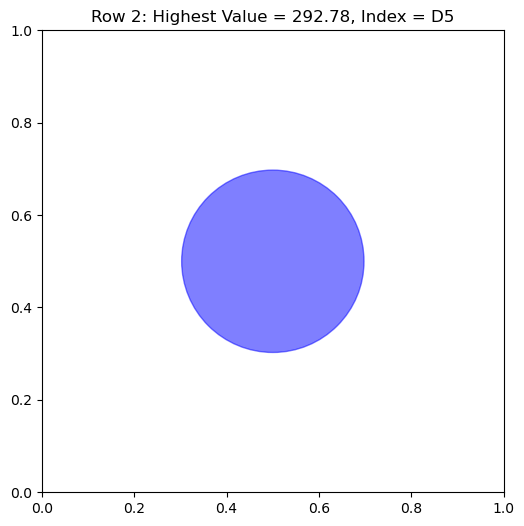

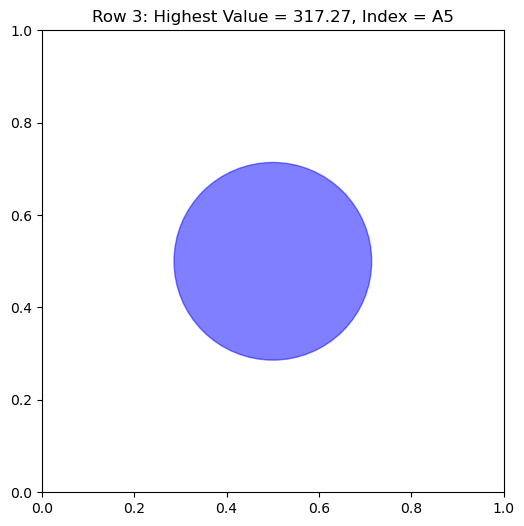

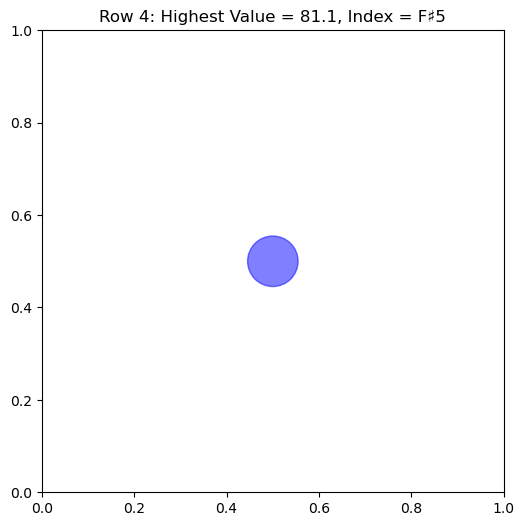

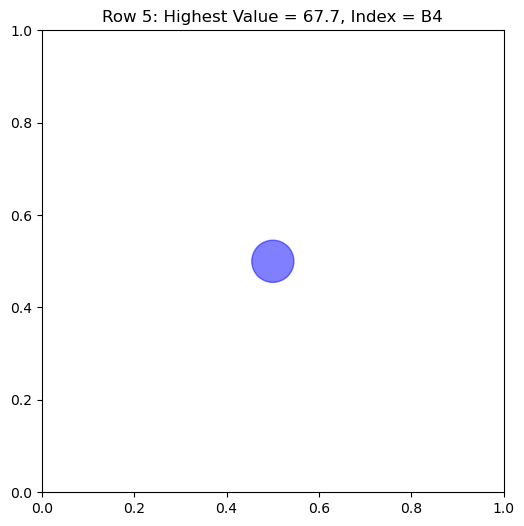

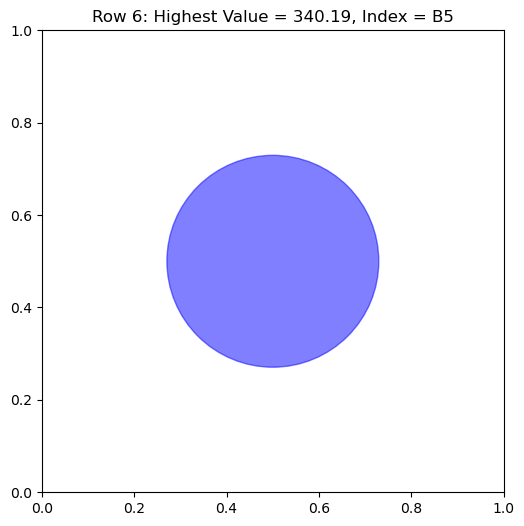

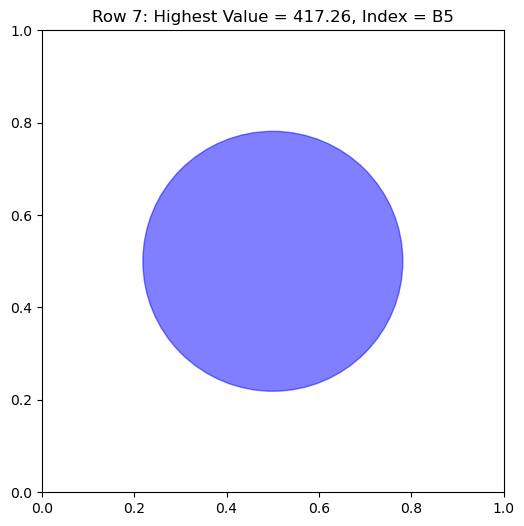

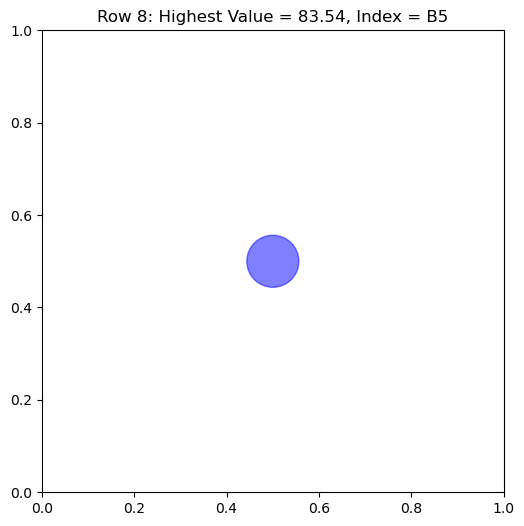

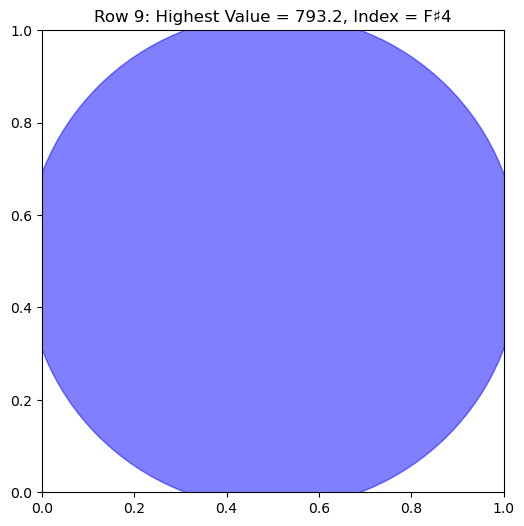

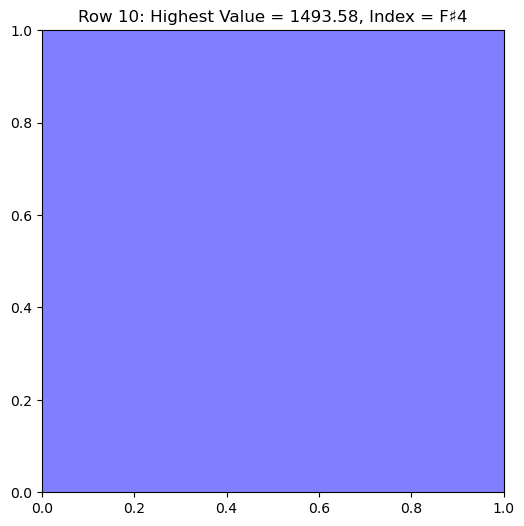

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv("processed_output.csv")

# Find the highest cell value within the first 10 rows
highest_value = df.iloc[:10].max().max()

# Filter out zeros and find the lowest non-zero value
lowest_nonzero_value = df[df != 0].min().min()

# Set the doubled figure size
figsize = (12, 6)

# Iterate over the first 10 rows
for i in range(10):
    # Get the row
    row = df.iloc[i]
    
    # Find the highest value in the row and its index
    highest_value_in_row = row.max()
    highest_value_index = row.idxmax()
    
    # Create a plot for each row with doubled figure size
    fig, ax = plt.subplots(figsize=figsize)
    
    # Draw a circle with radius reduced by 25%
    circle = plt.Circle((0.5, 0.5), highest_value_in_row / (highest_value - lowest_nonzero_value), color='blue', alpha=0.5)
    
    # Add the circle to the plot
    ax.add_artist(circle)
    
    # Set equal aspect ratio to ensure the circle looks like a circle
    ax.set_aspect('equal')
    
    # Set limits to ensure the circle fits within the plot
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    # Title for each plot including the highest value and its index
    ax.set_title(f'Row {i+1}: Highest Value = {highest_value_in_row}, Index = {highest_value_index}')
    
    # Show the plot
    plt.show()


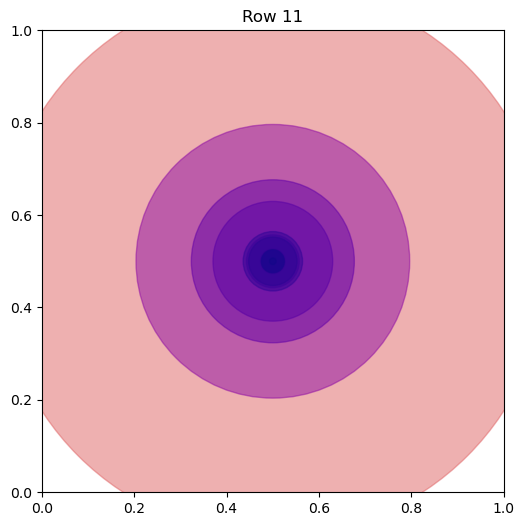

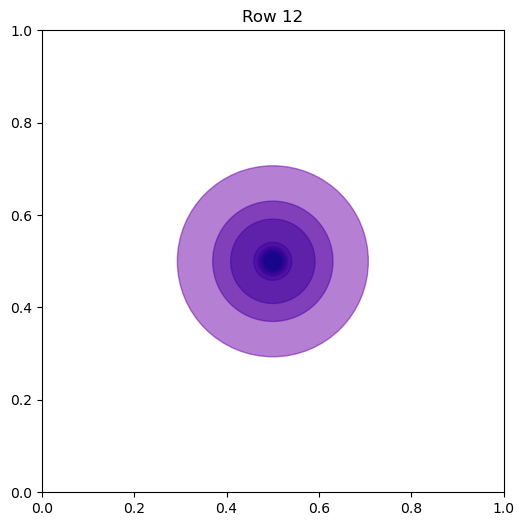

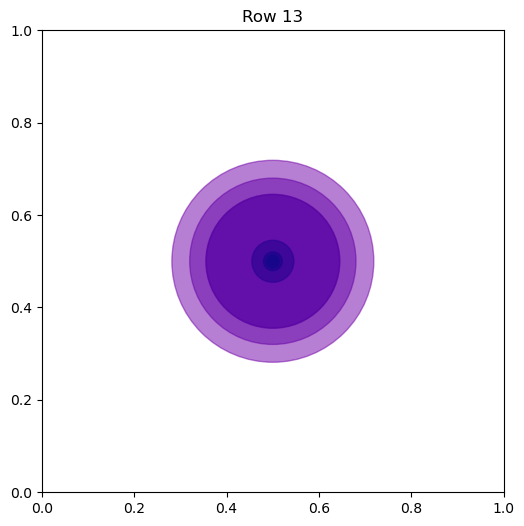

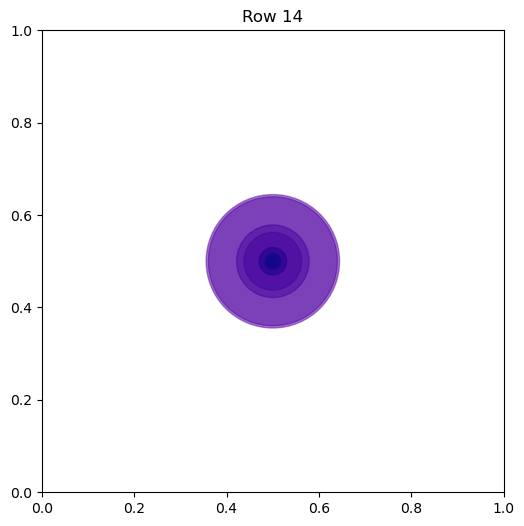

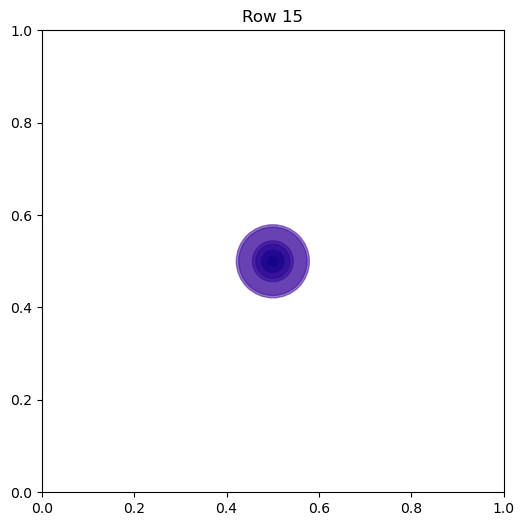

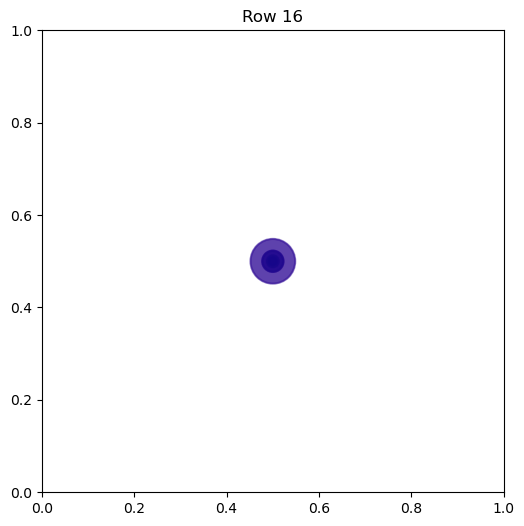

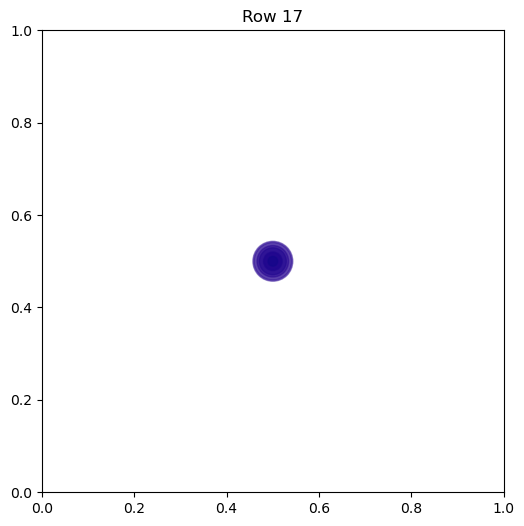

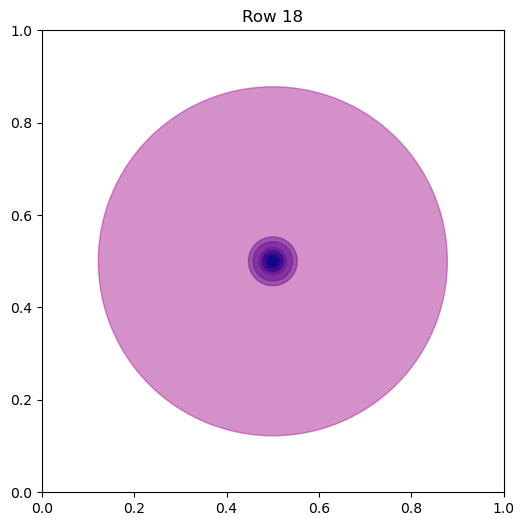

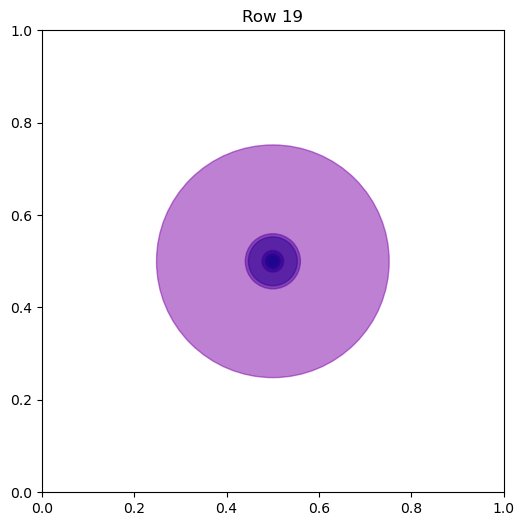

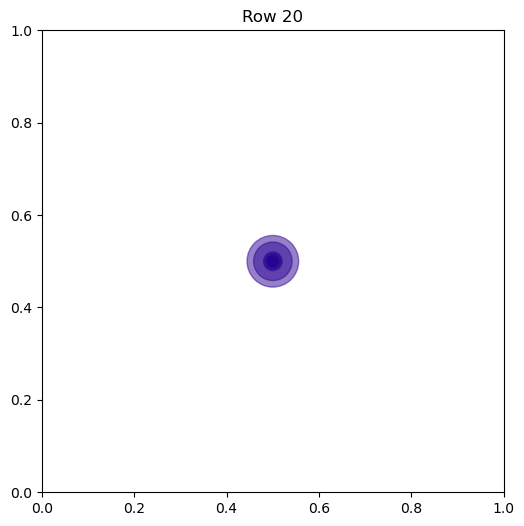

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file
df = pd.read_csv("processed_output.csv")

# Find the highest cell value within the first 10 rows
highest_value = df.iloc[:10].max().max()

# Filter out zeros and find the lowest non-zero value
lowest_nonzero_value = df[df != 0].min().min()

# Define the frequency range corresponding to visible light (approximate)
# Here, we'll consider the range of audible frequencies
lowest_freq = 60  # Hz (lowest audible frequency)
highest_freq = 7500  # Hz (highest audible frequency)

# Set the doubled figure size
figsize = (12, 6)

# Iterate over the first 10 rows
for i in range(10, 20):
    # Get the row
    row = df.iloc[i]
    
    # Find non-zero values and their indices in the row
    nonzero_values = row[row != 0]
    
    # Create a plot for each row with doubled figure size
    fig, ax = plt.subplots(figsize=figsize)
    
    # Draw a circle for each non-zero value in the row
    for value in nonzero_values:
        # Calculate the radius based on the value
        radius = value / (highest_value - lowest_nonzero_value)
        
        # Map the frequency to a color using 'plasma' colormap
        frequency = lowest_freq + (value - lowest_nonzero_value) / (highest_value - lowest_nonzero_value) * (highest_freq - lowest_freq)
        color = plt.cm.plasma(frequency / highest_freq)
        
        # Draw the circle with the calculated color
        circle = plt.Circle((0.5, 0.5), radius, color=color, alpha=0.5)
        ax.add_artist(circle)
    
    # Set equal aspect ratio to ensure the circles look like circles
    ax.set_aspect('equal')
    
    # Set limits to ensure the circles fit within the plot
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    # Title for each plot indicating the row number
    ax.set_title(f'Row {i+1}')
    
    # Show the plot
    plt.show()


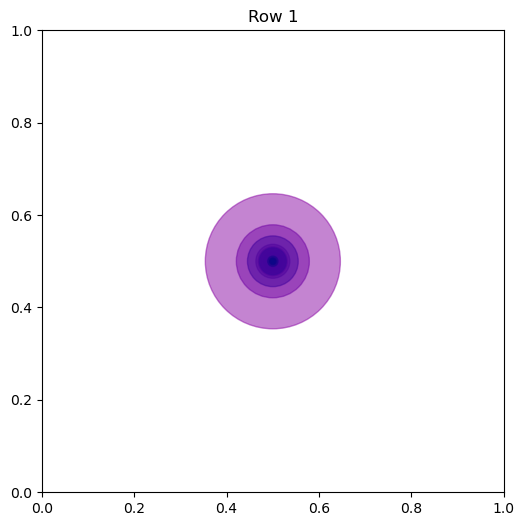

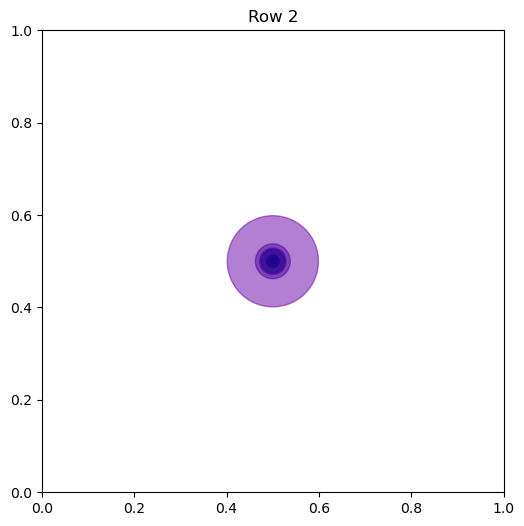

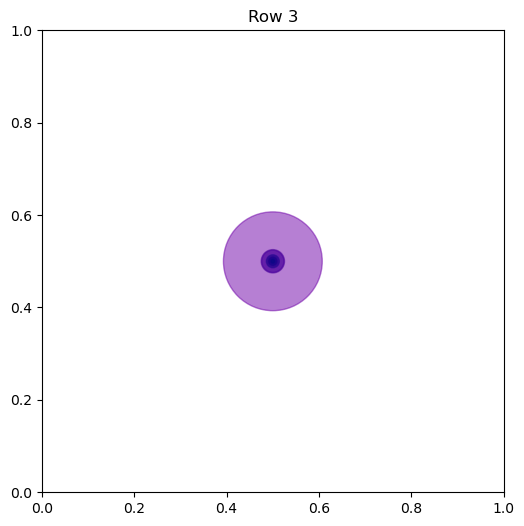

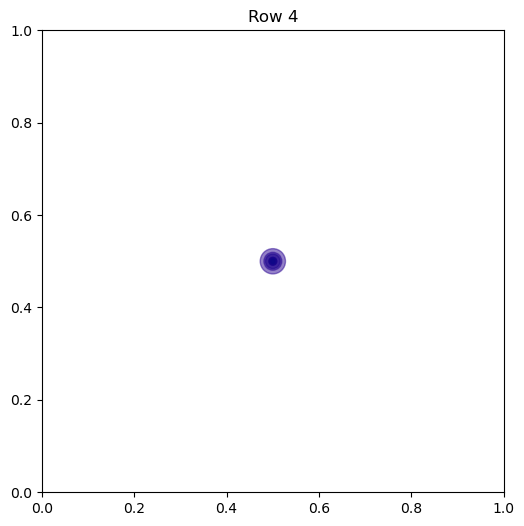

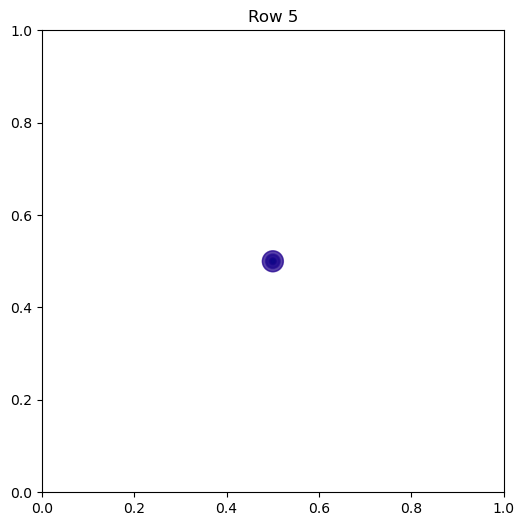

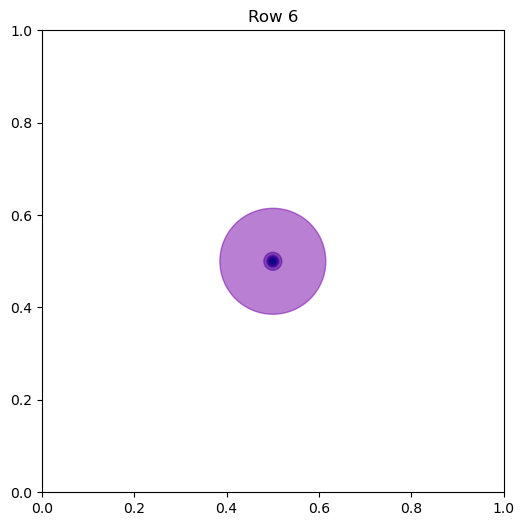

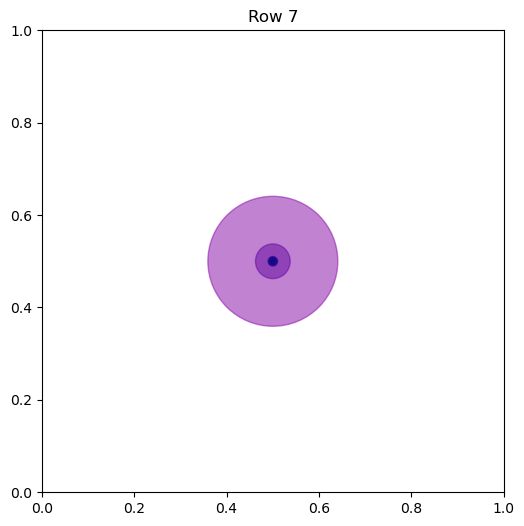

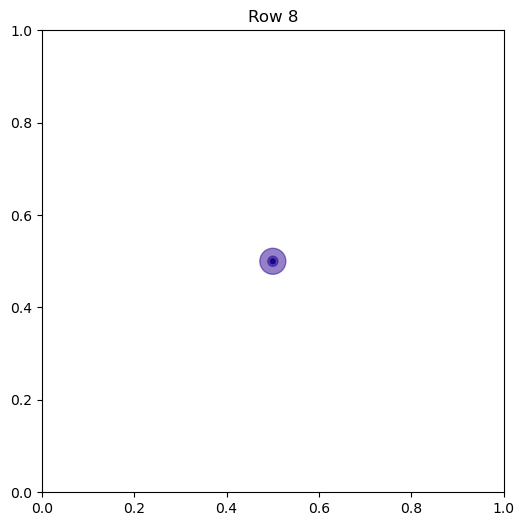

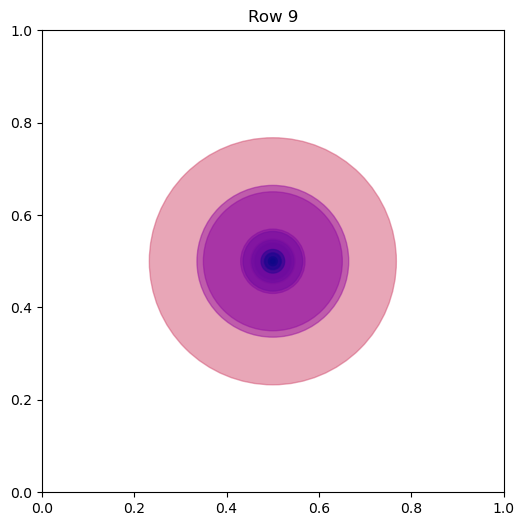

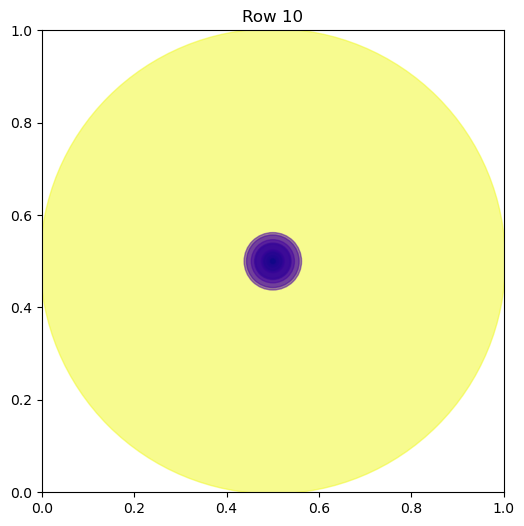

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read the CSV file
df = pd.read_csv("processed_output.csv")

# Find the highest cell value within the first 10 rows
highest_value = df.iloc[:10].max().max()

# Filter out zeros and find the lowest non-zero value
lowest_nonzero_value = df[df != 0].min().min()

# Define the frequency range corresponding to visible light (approximate)
# Here, we'll consider the range of audible frequencies
lowest_freq = 20  # Hz (lowest audible frequency)
highest_freq = 20000  # Hz (highest audible frequency)

# Set the doubled figure size
figsize = (12, 6)

# Iterate over the first 10 rows
for i in range(10):
    # Get the row
    row = df.iloc[i]
    
    # Find non-zero values and their indices in the row
    nonzero_values = row[row != 0]
    
    # Create a plot for each row with doubled figure size
    fig, ax = plt.subplots(figsize=figsize)
    
    # Draw a circle for each non-zero value in the row
    for value in nonzero_values:
        # Calculate the radius based on the value
        radius = (value / (highest_value - lowest_nonzero_value)) * 0.5  # Reduce the radius by half
        
        # Map the frequency to a color using 'plasma' colormap
        frequency = lowest_freq + (value - lowest_nonzero_value) / (highest_value - lowest_nonzero_value) * (highest_freq - lowest_freq)
        color = plt.cm.plasma(frequency / highest_freq)
        
        # Draw the circle with the calculated color
        circle = plt.Circle((0.5, 0.5), radius, color=color, alpha=0.5)
        ax.add_artist(circle)
    
    # Set equal aspect ratio to ensure the circles look like circles
    ax.set_aspect('equal')
    
    # Set limits to ensure the circles fit within the plot
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    
    # Title for each plot indicating the row number
    ax.set_title(f'Row {i+1}')
    
    # Show the plot
    plt.show()


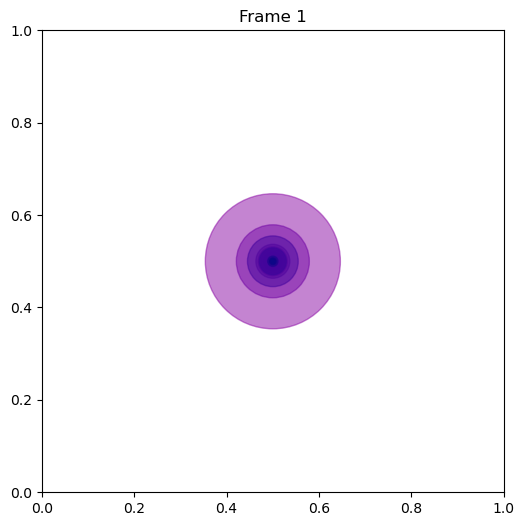

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

# Read the CSV file
df = pd.read_csv("processed_output.csv")

# Find the highest cell value within the first 10 rows
highest_value = df.iloc[:10].max().max()

# Filter out zeros and find the lowest non-zero value
lowest_nonzero_value = df[df != 0].min().min()

# Define the frequency range corresponding to visible light (approximate)
# Here, we'll consider the range of audible frequencies
lowest_freq = 20  # Hz (lowest audible frequency)
highest_freq = 20000  # Hz (highest audible frequency)

# Set the doubled figure size
figsize = (12, 6)

# Create a figure and axis
fig, ax = plt.subplots(figsize=figsize)

# Function to update the plot for each frame
def update(frame):
    ax.clear()
    row = df.iloc[frame]
    nonzero_values = row[row != 0]
    
    for value in nonzero_values:
        radius = (value / (highest_value - lowest_nonzero_value)) * 0.5
        frequency = lowest_freq + (value - lowest_nonzero_value) / (highest_value - lowest_nonzero_value) * (highest_freq - lowest_freq)
        color = plt.cm.plasma(frequency / highest_freq)
        circle = plt.Circle((0.5, 0.5), radius, color=color, alpha=0.5)
        ax.add_artist(circle)
    
    ax.set_aspect('equal')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(f'Frame {frame+1}')

# Create the animation
ani = FuncAnimation(fig, update, frames=len(df), interval=500)

# Save the animation as a sequence of images
ani.save('animation.gif', writer='pillow')

# plt.show()


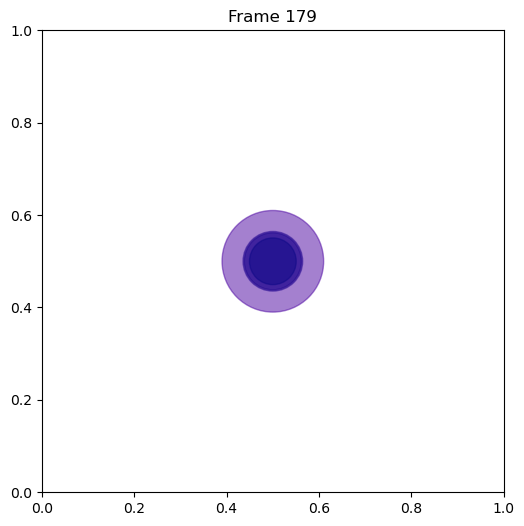

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation

# Read the CSV file
df = pd.read_csv("processed_output.csv")

# Find the highest cell value within the first 10 rows
highest_value = df.iloc[:10].max().max()

# Filter out zeros and find the lowest non-zero value
lowest_nonzero_value = df[df != 0].min().min()

# Define the frequency range corresponding to visible light (approximate)
# Here, we'll consider the range of audible frequencies
lowest_freq = 20  # Hz (lowest audible frequency)
highest_freq = 20000  # Hz (highest audible frequency)

# Set the doubled figure size
figsize = (12, 6)

# Create a figure and axis
fig, ax = plt.subplots(figsize=figsize)

# Interpolation function
def interpolate_data(row1, row2, alpha):
    return row1 * (1 - alpha) + row2 * alpha

# Function to update the plot for each frame
def update(frame):
    ax.clear()
    row1 = df.iloc[frame]
    if frame + 1 < len(df):
        row2 = df.iloc[frame + 1]
        for alpha in np.linspace(0, 1, 10):  # Interpolate 10 frames between each pair of rows
            interpolated_row = interpolate_data(row1, row2, alpha)
            plot_row(interpolated_row)
    else:
        plot_row(row1)
    
    ax.set_aspect('equal')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(f'Frame {frame+1}')

# Function to plot circles for a given row
def plot_row(row):
    nonzero_values = row[row != 0]
    for value in nonzero_values:
        radius = (value / (highest_value - lowest_nonzero_value)) * 0.5
        frequency = lowest_freq + (value - lowest_nonzero_value) / (highest_value - lowest_nonzero_value) * (highest_freq - lowest_freq)
        color = plt.cm.plasma(frequency / highest_freq)
        circle = plt.Circle((0.5, 0.5), radius, color=color, alpha=0.5)
        ax.add_artist(circle)

# Create the animation
ani = FuncAnimation(fig, update, frames=len(df), interval=50)  # Reduced interval for smoother animation

# Save the animation as a sequence of images
ani.save('animation.gif', writer='pillow', fps=30)  # Increase FPS for smoother animation

# plt.show()


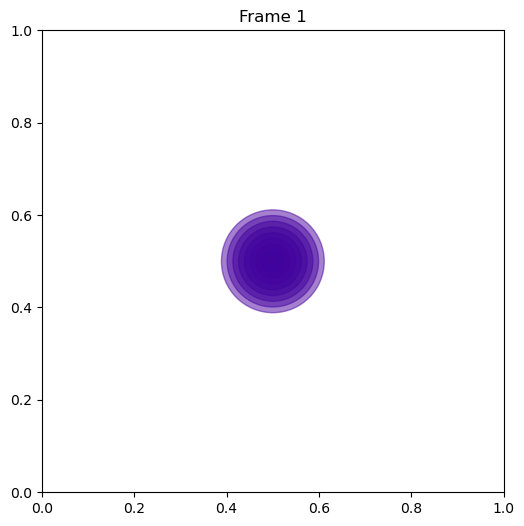

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation
import moviepy.editor as mp
import os

# Read the CSV file
df = pd.read_csv("processed_output.csv")

# Read the audio file
audio_clip = mp.AudioFileClip("chopin.wav")
duration = audio_clip.duration

# Calculate the number of frames based on the audio duration
num_frames = int(duration * 30)  # Assuming 30 frames per second

# Find the highest cell value within the first 10 rows
highest_value = df.iloc[:10].max().max()

# Filter out zeros and find the lowest non-zero value
lowest_nonzero_value = df[df != 0].min().min()

# Define the frequency range corresponding to visible light (approximate)
# Here, we'll consider the range of audible frequencies
lowest_freq = 20  # Hz (lowest audible frequency)
highest_freq = 20000  # Hz (highest audible frequency)

# Set the doubled figure size
figsize = (12, 6)

# Create a figure and axis
fig, ax = plt.subplots(figsize=figsize)

# Interpolation function
def interpolate_data(row1, row2, alpha):
    return row1 * (1 - alpha) + row2 * alpha

# Function to update the plot for each frame
def update(frame):
    ax.clear()
    row_idx = int(frame / (duration * 30 / len(df)))  # Map frame to corresponding row
    row1 = df.iloc[row_idx]
    if row_idx + 1 < len(df):
        row2 = df.iloc[row_idx + 1]
        for alpha in np.linspace(0, 1, 10):  # Interpolate 10 frames between each pair of rows
            interpolated_row = interpolate_data(row1, row2, alpha)
            plot_row(interpolated_row)
    else:
        plot_row(row1)
    
    ax.set_aspect('equal')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title(f'Frame {frame+1}')

# Function to plot circles for a given row
def plot_row(row):
    nonzero_values = row[row != 0]
    for value in nonzero_values:
        radius = (value / (highest_value - lowest_nonzero_value)) * 0.5
        frequency = lowest_freq + (value - lowest_nonzero_value) / (highest_value - lowest_nonzero_value) * (highest_freq - lowest_freq)
        color = plt.cm.plasma(frequency / highest_freq)
        circle = plt.Circle((0.5, 0.5), radius, color=color, alpha=0.5)
        ax.add_artist(circle)

# Create the animation
ani = FuncAnimation(fig, update, frames=num_frames, interval=33.3)  # Adjust interval for 30 fps

# Save the animation as a sequence of images
ani.save('frame.png', writer='pillow', fps=30, savefig_kwargs={'format': 'png'})  # Save frames as APNG images


In [9]:
# Set audio for the animation
video_clip = mp.VideoFileClip("frame.png")
final_clip = video_clip.set_audio(audio_clip)

# Write the synchronized animation with audio to a file
final_clip.write_videofile("output.mp4", codec="libx264")

OSError: MoviePy error: failed to read the duration of file frame.png.
Here are the file infos returned by ffmpeg:

ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with clang version 17.0.6
  configuration: --prefix=/d/bld/ffmpeg_1706918581257/_h_env/Library --cc=clang.exe --cxx=clang++.exe --nm=llvm-nm --ar=llvm-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --ld=lld-link --target-os=win64 --enable-cross-compile --toolchain=msvc --host-cc=clang.exe --extra-libs=ucrt.lib --extra-libs=vcruntime.lib --extra-libs=oldnames.lib --strip=llvm-strip --disable-stripping --host-extralibs= --disable-libopenvino --enable-gpl --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-pic --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libopus --pkg-config=/d/bld/ffmpeg_1706918581257/_build_env/Library/bin/pkg-config
  libavutil      58. 29.100 / 58. 29.100
  libavcodec     60. 31.102 / 60. 31.102
  libavformat    60. 16.100 / 60. 16.100
  libavdevice    60.  3.100 / 60.  3.100
  libavfilter     9. 12.100 /  9. 12.100
  libswscale      7.  5.100 /  7.  5.100
  libswresample   4. 12.100 /  4. 12.100
  libpostproc    57.  3.100 / 57.  3.100
Input #0, apng, from 'frame.png':
  Duration: N/A, bitrate: N/A
  Stream #0:0: Video: apng, rgba(pc, gbr/unknown/unknown), 1200x600, 30.30 fps, 30.30 tbr, 100k tbn
At least one output file must be specified
